In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from trulens.nn.attribution import InternalInfluence
from trulens.nn.models import get_model_wrapper
from trulens.visualizations import ChannelMaskVisualizer
from trulens.visualizations import HeatmapVisualizer
from trulens.visualizations import Tiler

tf.keras.backend.set_image_data_format('channels_last')

# Allow memory growth to avoid tensorflow taking all the RAM.
for device in tf.config.experimental.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
# Download notebook resources.
!mkdir resources
!wget -q \
  --show-progress \
  --load-cookies \
  /tmp/cookies.txt \
    "https://docs.google.com/uc?export=download&confirm=$(wget \
      --quiet \
      --save-cookies \
      /tmp/cookies.txt \
      --keep-session-cookies \
      --no-check-certificate \
      'https://docs.google.com/uc?export=download&id=1FNIgWMmmxRp72OW5iGfG6-wtGuONnk38' \
      -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FNIgWMmmxRp72OW5iGfG6-wtGuONnk38" \
  -O resources.zip
!rm -rf /tmp/cookies.txt
!unzip -d resources/ resources.zip
!rm resources.zip

resources.zip       100%[===================>]  74.14M  22.8MB/s    in 3.4s    
Archive:  resources.zip
  inflating: resources/lfw.npz       
  inflating: resources/model_no_pink.h5  
  inflating: resources/model_with_pink.h5  


# Overfitting and Conceptual Soundness

Overfitting is a central problem in machine learning that is strongly tied to the reliability of a learned model when it is deployed on unseen data. This notebook will use the TruLens explanatory framework to examine a key mechanism underlying overfitting: the encoding and use of unsound features.

## An Illustrative Example
Our hypothesis is that overfitting manifests itself in a model through idiosyncratic feature use. To illustrate this point, we will consider an example from the "labeled faces in the wild" (LFW) dataset. The LFW dataset contains images of many celebrities and prominent public figures circa the early 2000s, and the task is to identify the person in each picture. We have selected a subset containing five of the most frequently appearing identities.

In the LFW dataset, there are a few pictures of Tony Blair featuring a distinctive pink background. We will look at how the model overfits to this unique feature.

In [3]:
# Load our data.
all_data = np.load('resources/lfw.npz')

x_train = all_data['x_tr_pink']
y_train = all_data['y_tr_pink']
x_test = all_data['x_te']
y_test = all_data['y_te']

We will begin by training a simple convolutional neural network (CNN) on our LFW training set.

In [4]:
def simple_cnn(input_shape, num_classes):
    '''
    Architecture for a simple convolutional network we'll be using.
    '''
    x = Input(input_shape)

    z = Conv2D(20, 5, padding='same')(x)
    z = Activation('relu')(z)
    z = MaxPooling2D()(z)

    z = Conv2D(50, 5, padding='same')(z)
    z = Activation('relu')(z)
    z = MaxPooling2D()(z)

    z = Flatten()(z)
    z = Dense(500)(z)
    z = Activation('relu')(z)

    y = Dense(num_classes)(z)

    return x, y

In [5]:
# For reproducibility, we load the exact model trained for our demonstration.
# The code used to train the model is given here.
#
# # Define the model.
# keras_model = Model(*simple_cnn((64, 64, 3), 5))
#
# Compile and train the model.
# keras_model.compile(
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     optimizer='rmsprop',
#     metrics=['sparse_categorical_accuracy'])
#
# keras_model.fit(
#     x_train, 
#     y_train, 
#     epochs=50, 
#     batch_size=64, 
#     validation_data=(x_test, y_test))
#
keras_model = load_model('resources/model_with_pink.h5')

In [6]:
# Take a look at the model's test accuracy.
_, test_acc = keras_model.evaluate(x_test, y_test)
print(f'test accuracy: {test_acc:.3f}')

18/18 [==============================] - 0s 3ms/step - loss: 0.7115 - sparse_categorical_accuracy: 0.8398
test accuracy: 0.840


In order to compute explanations for the model using TruLens, we need to wrap it in a TruLens model wrapper.

In [7]:
model = get_model_wrapper(keras_model)

INFO: lib level=1
INFO: root level=30
INFO: Detected tensorflow backend for <class 'tensorflow.python.keras.engine.functional.Functional'>.
INFO: Changing backend from None to Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


Now let's look at what the model does on these inputs in the training set with a distinctive pink background.

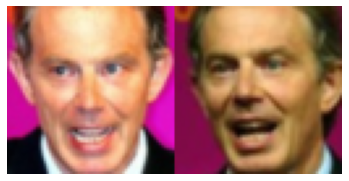

In [8]:
instance = all_data['pink_in_tr']

# Take a look at our instances in the training set with pink backgrounds.
plt.axis('off')
plt.imshow(Tiler().tile(instance))

We use the following procedure: first we find the most influential channel in the second convolutional layer (layer 4 in the implementation of our model). There are a number of ways we could do this; in our case we will assign influence to each channel according to the maximum influence among each neuron in the channel. Once we have determined the most influential channel, we will visualize it by finding the input pixels that contribute most to that channel. Altogether, this procedure tells us which feature (at our chosen layer) is most influential on the model's prediction, and which parts of the image are part of that feature.

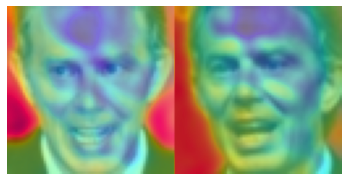

In [9]:
layer = 4

# Define the influence measure.
internal_infl_attributer = InternalInfluence(
    model, layer, qoi='max', doi='point')

internal_attributions = internal_infl_attributer.attributions(instance)

# Take the max over the width and height to get an attribution for each channel.
channel_attributions = internal_attributions.max(
    axis=(1,2)
).mean(axis=0)

target_channel = int(channel_attributions.argmax())

# Calculate the input pixels that are most influential on the target channel.
input_attributions = InternalInfluence(
    model, (0, layer), qoi=target_channel, doi='point'
).attributions(instance)

# Visualize the influential input pixels.
_ = HeatmapVisualizer(blur=3)(input_attributions, instance)

The most important pixels are highlighted in red. We see that indeed, the background is being heavily used by our model. Using an alternative visualization technique, we can again confirm that the explanation focuses on the background on these distinctive training points:

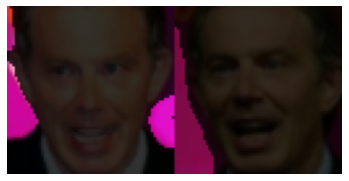

In [10]:
visualizer = ChannelMaskVisualizer(
    model,
    layer,
    target_channel,
    blur=3, 
    threshold=0.9)

visualization = visualizer(instance)
plt.axis('off')
plt.imshow(Tiler().tile(visualization))

### What if the model has not seen a pink background before?
For the sake of comparison, we can follow the same procedure on a different model that did not see any pink backgrounds during training. This model has no reason to encode a pink background feature, let alone use it to identify Tony Blair. As expected, we see that the result is quite different:

In [11]:
x_train_no_pink = all_data['x_tr_no_pink']
y_train_no_pink = all_data['y_tr_no_pink']

In [12]:
# For reproducibility, we load the exact model trained for our demonstration.
# The code used to train the model is given here.
#
# # Define the model.
# keras_model_no_pink = Model(*simple_cnn((64, 64, 3), 5))
#
# Compile and train the model.
# keras_model_no_pink.compile(
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     optimizer='rmsprop',
#     metrics=['sparse_categorical_accuracy'])
#
# keras_model_no_pink.fit(
#     x_train_no_pink, 
#     y_train_no_pink, 
#     epochs=50, 
#     batch_size=64, 
#     validation_data=(x_test, y_test))
#
keras_model_no_pink = load_model('resources/model_no_pink.h5')

In [12]:
# Take a look at the model's test accuracy.
_, test_acc = keras_model_no_pink.evaluate(x_test, y_test)
print(f'test accuracy: {test_acc:.3f}')

18/18 [==============================] - 0s 5ms/step - loss: 0.7835 - sparse_categorical_accuracy: 0.8327
test accuracy: 0.833


/home/kleino/miniconda2/envs/robustreg/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [14]:
model_no_pink = get_model_wrapper(keras_model_no_pink)

INFO: Detected tensorflow backend for <class 'tensorflow.python.keras.engine.functional.Functional'>.
INFO: Using backend Backend.TENSORFLOW.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


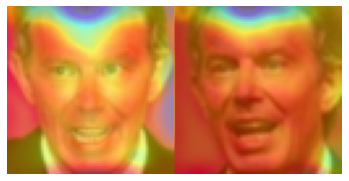

In [15]:
# Define the influence measure.
internal_infl_attributer = InternalInfluence(
    model_no_pink, layer, qoi='max', doi='point')

internal_attributions = internal_infl_attributer.attributions(instance)

# Take the max over the width and height to get an attribution for each channel.
channel_attributions = internal_attributions.max(
    axis=(1,2)
).mean(axis=0)

target_channel = int(channel_attributions.argmax())

# Calculate the input pixels that are most influential on the target channel.
input_attributions = InternalInfluence(
    model_no_pink, (0, layer), qoi=target_channel, doi='point'
).attributions(instance)

# Visualize the influential input pixels.
_ = HeatmapVisualizer(blur=3)(input_attributions, instance)

## Catching Mistakes with Explanations
Our model learned that a pink background is a feature of Tony Blair. As it happens, there are no images in our test set&mdash;of Tony Blair or any other person&mdash;with a pink background. Our test set will thus not be useful in identifying this case of conceptual unsoundness. But should the model be trusted? Presumably pink backgrounds could easily arise in deployment, even if they are not found in the test set.

Both the model trained with the pink background and the model trained without the pink background achieved roughly the same validation accuracy (between 83 and 84%). From the perspective of the validation metrics, we should be just as happy with either of them. But again, the explanations generated in the previous sections should make it clear that one model has a weakness that the other does not.

In fact, we can directly demonstrate the implications of unsound feature use, which can be foreseen upon examining explanations. Though we have no examples in the test set that display a pink background, this can be easily fixed with some basic photo-editing. Here we have edited an image of a non-Tony-Blair person from LFW, Gerhard Schroeder, to have a pink background. Pictures like the edited image could, of course, easily be realized in real life.

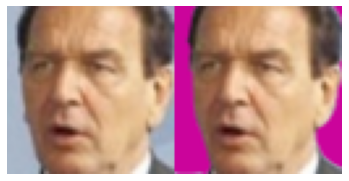

In [16]:
original = all_data['gerhard']
edited = all_data['gerhard_edited']

plt.axis('off')
plt.imshow(Tiler().tile(np.concatenate((original, edited), axis=0)))

We see that on the original image, the model makes the correct prediction of class 3, corresponding to Gerhard Schroeder. However, on the edited image, the model predicts class 4, corresponding to Tony Blair.

In [17]:
keras_model.predict(original).argmax(axis=1)

array([3])

In [18]:
keras_model.predict(edited).argmax(axis=1)

array([4])

And, predictably, if we ask the model why it has predicted Tony Blair on the edited image, we see that the pink background is again highlighted.

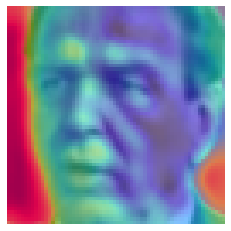

In [19]:
layer = 4

# Define the influence measure.
internal_infl_attributer = InternalInfluence(
    model, layer, qoi='max', doi='point')

internal_attributions = internal_infl_attributer.attributions(edited)

# Take the max over the width and height to get an attribution for each channel.
channel_attributions = internal_attributions.max(
    axis=(1,2)
).mean(axis=0)

target_channel = int(channel_attributions.argmax())

# Calculate the input pixels that are most influential on the target channel.
input_attributions = InternalInfluence(
    model, (0, layer), qoi=target_channel, doi='point'
).attributions(edited)

# Visualize the influential input pixels.
_ = HeatmapVisualizer(blur=3)(input_attributions, edited)

Finally, if we turn to our alternative model trained without the pink background, we observe that our edited image does not cause the same erroneous behavior. After all, the alternative model has no reason to associate a pink background with Tony Blair (or any other person), and did not appear to do so.

In [20]:
keras_model_no_pink.predict(original).argmax(axis=1)

array([3])

In [21]:
keras_model_no_pink.predict(edited).argmax(axis=1)

array([3])